Dataprocess.ipynb 버젼은 코랩 환경에서 데이터 다운로드 받고, 하나씩 결과물을 보여주는 과정이며,

실제 데이터 셋 가공은 process.py 파일에서 진행

1. 스탠포드 데이터 셋 압축파일 받기
2. 파일 네이밍을 강아지 종으로 깔끔하게 짜르고, 폴더 역시 train/test 분리

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import torch
import os
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline  
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(torch.__version__))

# Device Configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("This notebook use [%s]."%(device))

PyTorch version:[1.7.0+cu101].
This notebook use [cuda:0].


로컬 pc에서 데이터 받은 후, 로컬 pc에서 파이썬 파일로 전처리 함. 그리고 압축하여 구글 드라이브에 올리고

구글 드라이브에서 압축풀기

In [39]:
# !unzip -uq "/content/drive/MyDrive/RogerHeederer/AI_TECH_Course/Ustage/3주차/DogClassify/dataset.zip" -d "/content/drive/MyDrive/RogerHeederer/AI_TECH_Course/Ustage/3주차/DogClassify/dataset"

In [ ]:
EPOCHS = 100
BATCH_SIZE=16
LEARNING_RATE=0.001

In [ ]:

from torchvision import datasets, transforms, models

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

DATASET_PATH = "/content/drive/MyDrive/RogerHeederer/AI_TECH_Course/Ustage/3주차/DogClassify/dataset"
# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(DATASET_PATH + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(DATASET_PATH + '/test', transform=test_transforms)

train_iter = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
test_iter = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)


print("Preparing dataset done!")

Preparing dataset done!


# Transformed 된 데이터 확인해보기

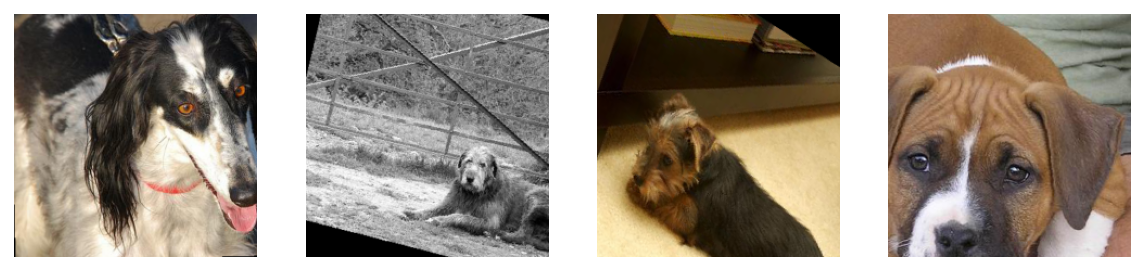

In [ ]:
# transform된 데이터를 뿌려준다
data_iter = iter(test_iter)
images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=True)

In [ ]:
class Model(nn.Module):
    def __init__(self, input_size = [3, 224, 224],
                 hidden_size=[32,64], 
                 num_classes=119, init_weight="he", init_bias="zero"):
        super(Model, self).__init__()

        self.init_weight = init_weight
        self.init_bias = init_bias

        layer_list = []
        prev_channel = input_size[0]
        
        for idx in range(len(hidden_size)):
            layer_list.append(nn.Conv2d(prev_channel, hidden_size[idx], kernel_size=3, stride=1, padding=1))
            layer_list.append(nn.BatchNorm2d(hidden_size[idx]))
            layer_list.append(nn.ReLU(True))
            layer_list.append(nn.MaxPool2d(kernel_size=2, stride=2))
            prev_channel = hidden_size[idx]
        
        layer_list.append(nn.Flatten())
        feature_size = int(input_size[1]/ 2**len(hidden_size))
        layer_list.append(nn.Linear(feature_size*feature_size*prev_channel, 119))
        
        self.net = nn.Sequential(*layer_list)

        self.init_params()

    def init_params(self):
        
        init_weight_method = {
        "he": nn.init.kaiming_normal_, 
        "xavier": nn.init.xavier_normal_
        }
        assert self.init_weight in init_weight_method.keys(), f'Select the weight initialization method in {list(init_weight_method.keys())}'
        
        init_bias_method = {
            "zero": nn.init.zeros_, 
            "uniform": nn.init.uniform_
        }
        assert self.init_bias in init_bias_method.keys(), f'Select the bias initialization method in {list(init_bias_method.keys())}'

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init_weight_method[self.init_weight](m.weight)
                init_bias_method[self.init_bias](m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                
    def forward(self, X):
        return self.net(X)

In [ ]:
# 모델 파라미터 체크를 위한 임의 모델 생성
test_model = Model(input_size = [3, 224, 224], hidden_size=[32,64], num_classes=119, init_weight="he", init_bias="zero")

total_params = 0
for param_name, param in test_model.named_parameters():
    if param.requires_grad:
        total_params += len(param.reshape(-1))
print(f"test model's Number of Total Parameters: {total_params:,d}")

test model's Number of Total Parameters: 23,903,479


In [ ]:
def test_eval(model, data_iter, batch_size):
    with torch.no_grad():
        test_loss = 0
        total = 0
        correct = 0
        model.eval()
        for batch_img, batch_lab in data_iter:
            X = batch_img.view(-1, 3, 224, 224).to(device)
            Y = batch_lab.to(device)
            y_pred = model(X)
            _, predicted = torch.max(y_pred.data, 1)
            correct += (predicted == Y).sum().item()
            total += batch_img.size(0)
        val_acc = (100 * correct / total)
        model.train()
    return val_acc

In [ ]:
print_every = 1
best_accuracy = 0
print("Start training !")
checkpoint_dir = "/content/drive/MyDrive/RogerHeederer/AI_TECH_Course/Ustage/3주차/DogClassify/weights"

if os.path.exists(checkpoint_dir):
    model = torch.load( f'{checkpoint_dir}/model.pt') 
    model.load_state_dict(
        torch.load( f'{checkpoint_dir}/model_state_dict.pt')) 
    checkpoint = torch.load(f'{checkpoint_dir}/all.tar')  
#     model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    
else:
    model = Model(hidden_size=[64, 32, 64]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


# Training loop
for epoch in range(EPOCHS):
    loss_val_sum = 0
    for batch_img, batch_lab in train_iter:

        X = batch_img.view(-1, 3, 224, 224).to(device)
        Y = batch_lab.to(device)
        
        # Inference & Calculate los
        y_pred = model.forward(X)
        loss = criterion(y_pred, Y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_val_sum += loss
        
    if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
        # accr_val = M.test(x_test, y_test, batch_size)
        loss_val_avg = loss_val_sum / len(train_iter)
        accr_val = test_eval(model, test_iter, BATCH_SIZE)
        print(f"epoch:[{epoch+1}/{EPOCHS}] cost:[{loss_val_avg:.3f}] test_accuracy:[{accr_val:.3f}]")

    if accr_val > best_accuracy:
        if not os.path.exists(checkpoint_dir):
            os.mkdir(checkpoint_dir)
        print(f"Model saved : acc - {accr_val}")

        torch.save(model, f'{checkpoint_dir}/model.pt')  
        torch.save(model.state_dict(), 
                   f'{checkpoint_dir}/model_state_dict.pt')  
        torch.save({
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict()
            }, f'{checkpoint_dir}/all.tar')  

print("Training Done !")

Start training !
epoch:[1/100] cost:[4.135] test_accuracy:[9.666]
Model saved : acc - 9.666342727567217
epoch:[2/100] cost:[4.138] test_accuracy:[9.997]
Model saved : acc - 9.996760609005507
epoch:[3/100] cost:[4.140] test_accuracy:[10.010]
Model saved : acc - 10.00971817298348
epoch:[4/100] cost:[4.128] test_accuracy:[9.595]
Model saved : acc - 9.59507612568837


KeyboardInterrupt: ignored

test_accyracy가 학습이 계속 되어도 개선이 안되어 중지시킴


In [ ]:
test_iter = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
data_iter = iter(test_iter)
images, labels = next(data_iter)

In [ ]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    ax.set_title(title)
    return ax

In [ ]:
n_sample = 16
# sample_indices = np.random.choice(len(mnist_test.targets), n_sample, replace=False)
test_x = images[:n_sample]
test_y = labels[:n_sample]

with torch.no_grad():
    model.eval()
    y_pred = model.forward(test_x.view(-1, 3, 224, 224).type(torch.float).to(device))
    model.train()
    
y_pred = y_pred.argmax(axis=1)

plt.figure(figsize=(20, 20))

for idx in range(n_sample):
    ax = plt.subplot(4, 4, idx+1)
    title = f"Predict: {y_pred[idx]}, Label: {test_y[idx]}"
    imshow(test_x[idx], ax, title)

plt.show()

Output hidden; open in https://colab.research.google.com to view.